In [27]:
!pip3 install timm
!pip install super-image


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

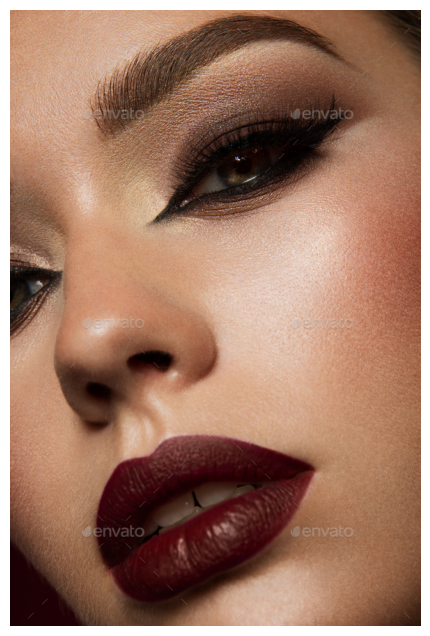

In [64]:
img_path = 'content/model_google_2.jpg'
img = plt.imread(img_path)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(img)
plt.show()

In [49]:
## THIS IS THE MAIN CODE FOR DEPTH SEGMENTATION WITH GRAYSCALE APPLIED FOR A BETTER VISUALIZATION
def load_midas_model(model_type = "DPT_Large", device = None):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas.to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "DPT_Large":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    return midas, transform

def preprocess_image(img_path, transform, device):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)
    return input_batch, img

def run_inference(midas, input_batch, original_img, input_mode):
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size = original_img.shape[:2],
            mode = input_mode,
            align_corners = False,
        ).squeeze()
    depth_map = prediction.cpu().numpy()
    return depth_map

def normalize_depth_map(depth_map):
    normalized_depth = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX ).astype(np.uint8)
    return normalized_depth

def display_image(image, title = "Image", cmap = "gray"):
    plt.figure(figsize = (8,8))
    plt.imshow(image, cmap = cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def process_depth_map(depth_map, title):
    depth_map_normalized = normalize_depth_map(depth_map)
    display_image(depth_map_normalized, title)


def run_midas(img_path, model_type = "DPT_Large", device = None, title = "Output", input_mode = "bilinear"):
    midas, transform = load_midas_model(model_type, device)
    input_batch, original_img = preprocess_image( img_path, transform, device)
    depth_map = run_inference(midas, input_batch, original_img, input_mode)
    normalized_depth_map = normalize_depth_map(depth_map)
    final_image = display_image(normalized_depth_map, title)
    return final_image

    
    

Using cache found in /Users/pranamshetty/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/pranamshetty/.cache/torch/hub/intel-isl_MiDaS_master


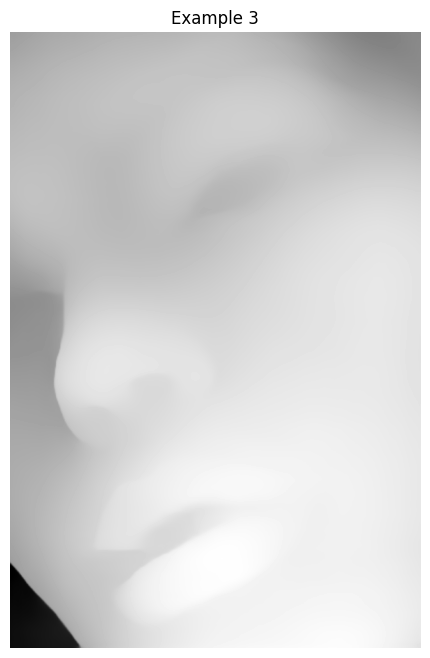

In [65]:
img_path = "content/model_google_2.jpg" #change the image path to the image you want to run the depth segmentation on
run_midas(img_path, title = "Example 3", device = "mps", input_mode = "bilinear") #change the device to "cuda" if you want to run the code on gpu, read docs for inputmode types for interpolation
# NOTE 
#as i am using apple silicon, the bicubic mode WILL NOT WORK if you set the device to mps(apple's GPU) 
#if you want to run the code on gpu, make sure to change the mode to bilinear else it will through an error